<a href="https://colab.research.google.com/github/jassem-1/bone-fracture-detection/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing Image 1...
Original Image:


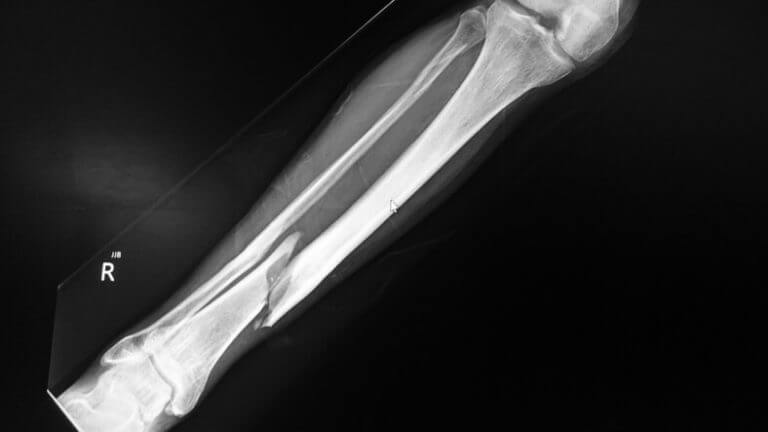

Binary Image After Thresholding:


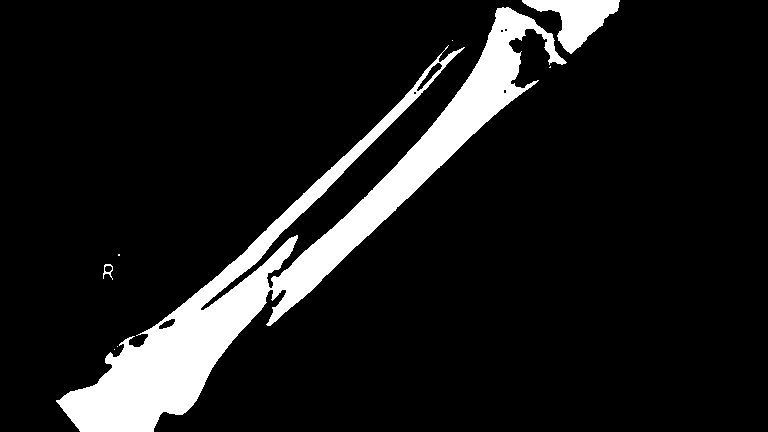

Cleaned Binary Image (Largest White Areas Retained):


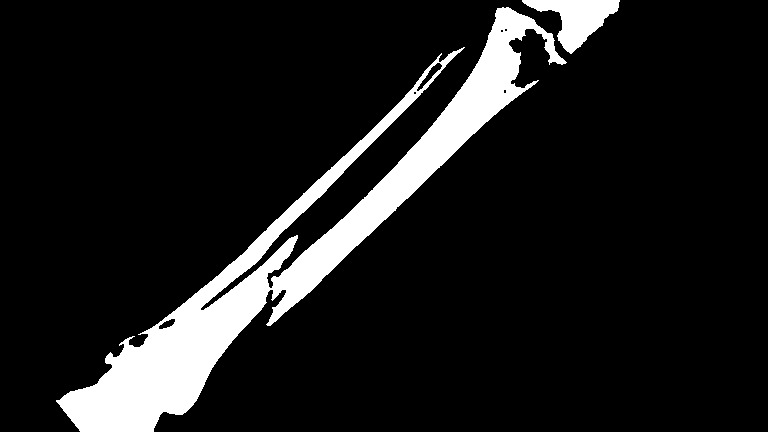

Binary Image After Breaking Thin Connections:


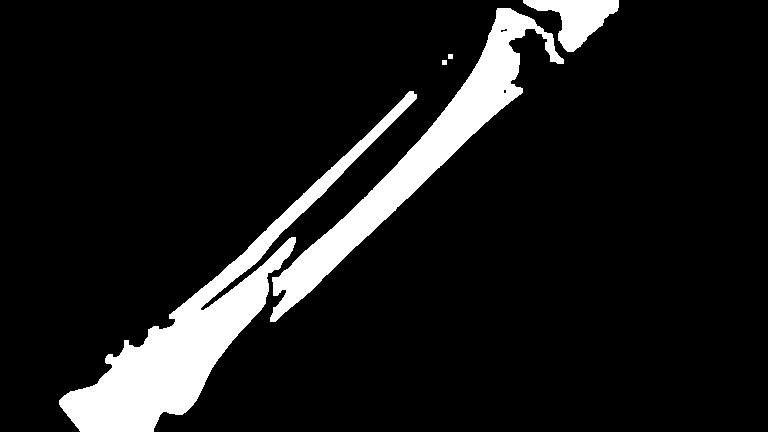

Cleaned Binary Image after disconnecting:


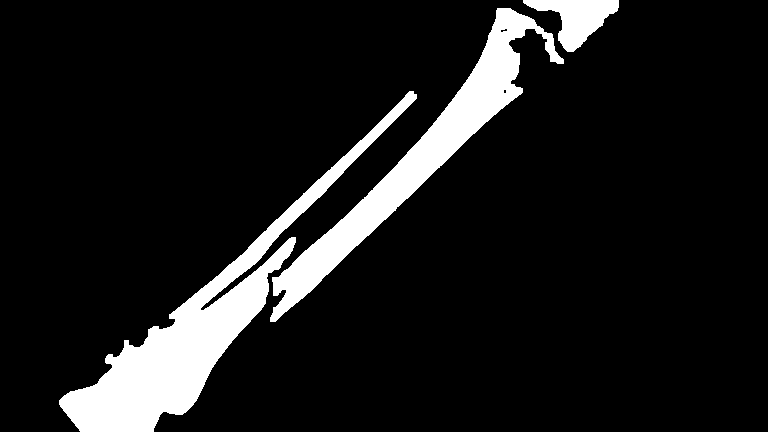

Segmented Image:


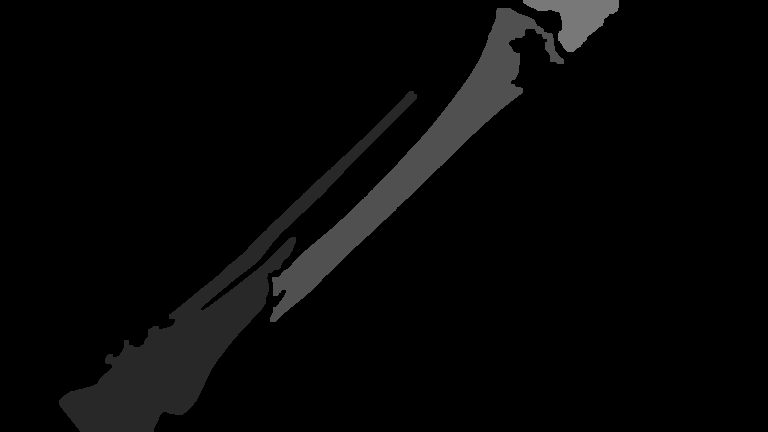

Minimum distance is 4.47 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:


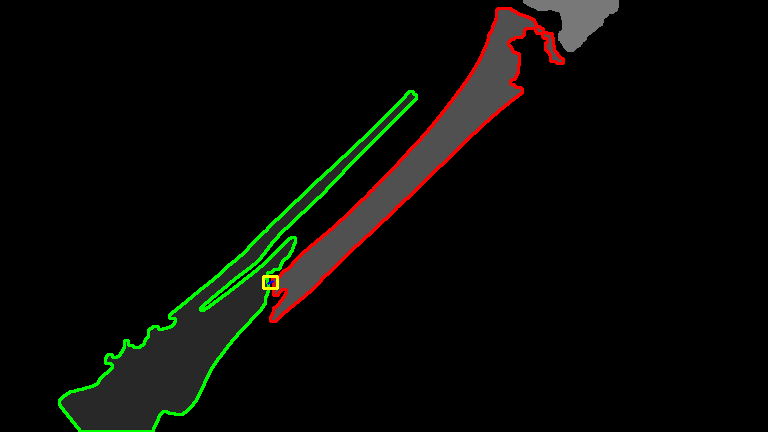

Processing Image 2...
Original Image:


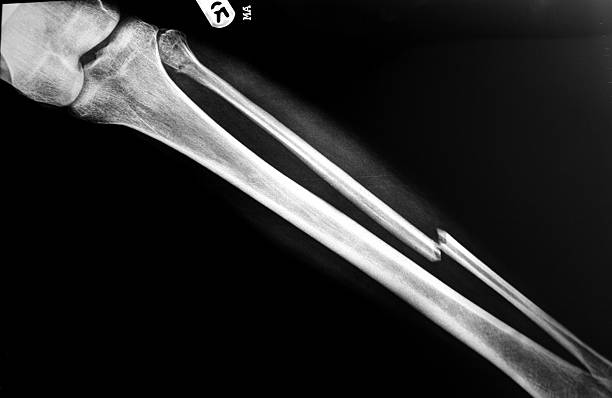

Binary Image After Thresholding:


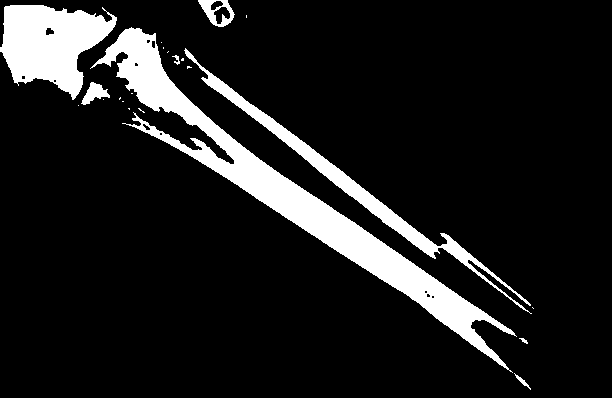

Cleaned Binary Image (Largest White Areas Retained):


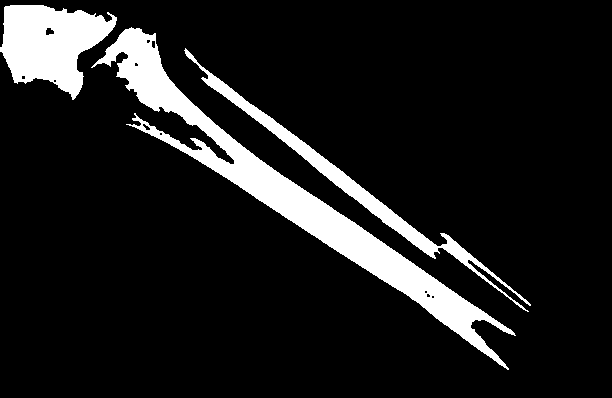

Binary Image After Breaking Thin Connections:


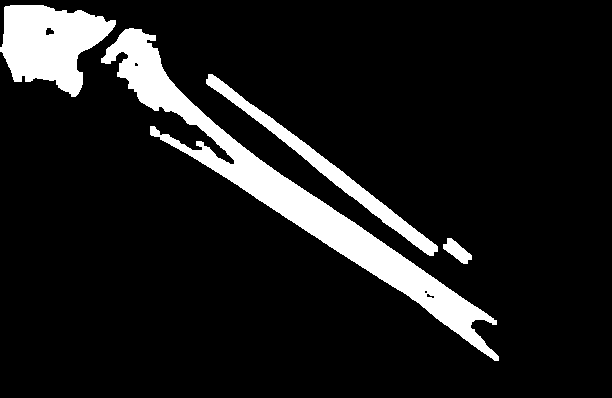

Cleaned Binary Image after disconnecting:


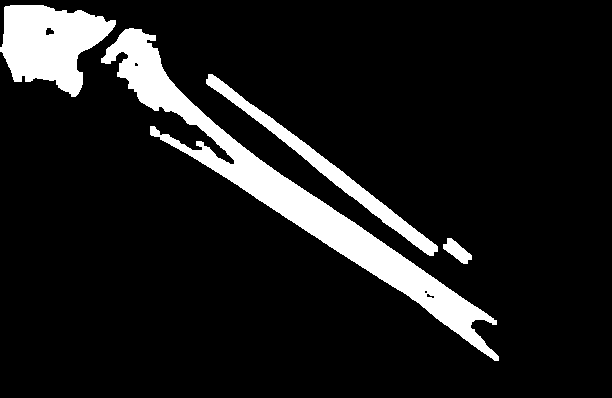

Segmented Image:


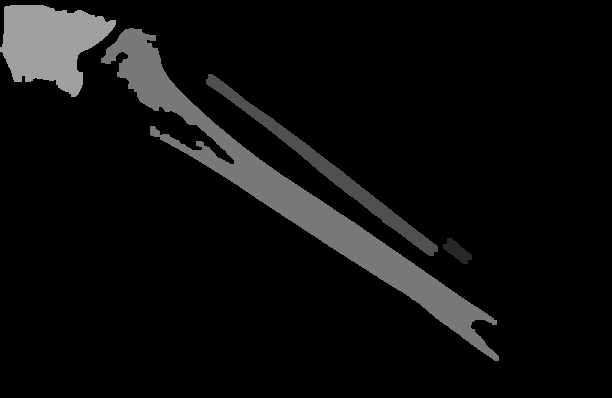

Minimum distance is 6.32 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:


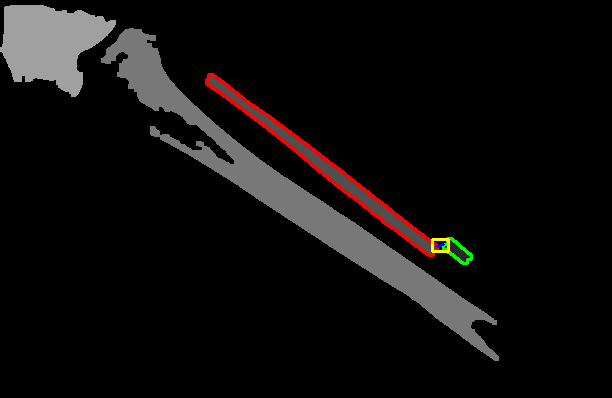

Processing Image 3...
Original Image:


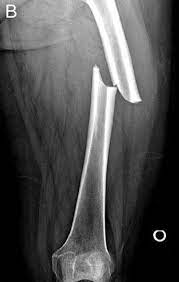

Binary Image After Thresholding:


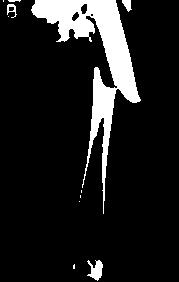

Cleaned Binary Image (Largest White Areas Retained):


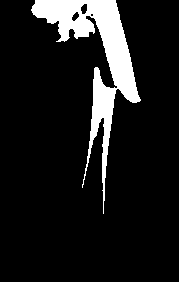

Binary Image After Breaking Thin Connections:


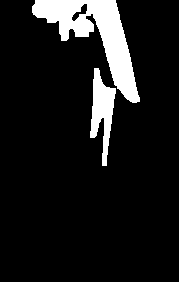

Cleaned Binary Image after disconnecting:


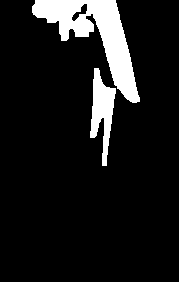

Segmented Image:


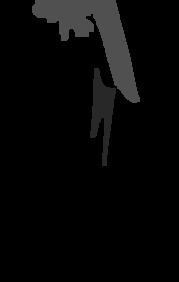

Minimum distance is 2.00 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:


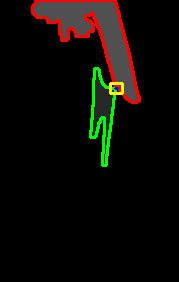

Processing Image 4...
Original Image:


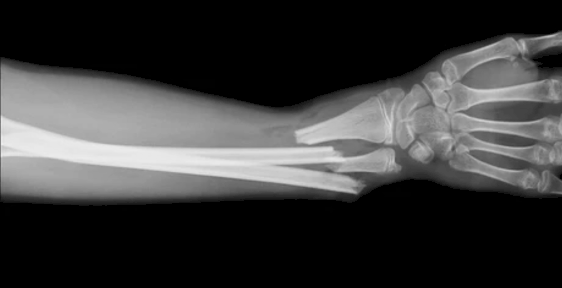

Binary Image After Thresholding:


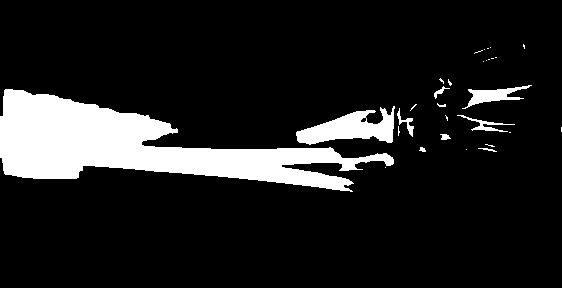

Cleaned Binary Image (Largest White Areas Retained):


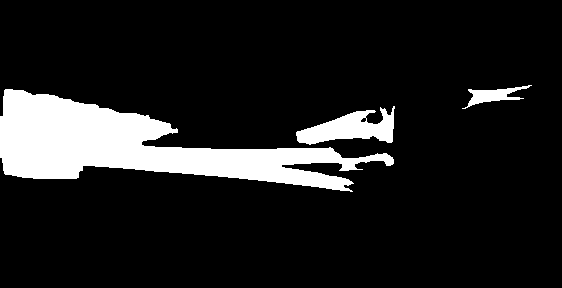

Binary Image After Breaking Thin Connections:


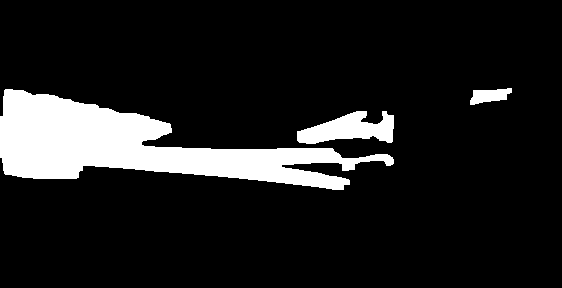

Cleaned Binary Image after disconnecting:


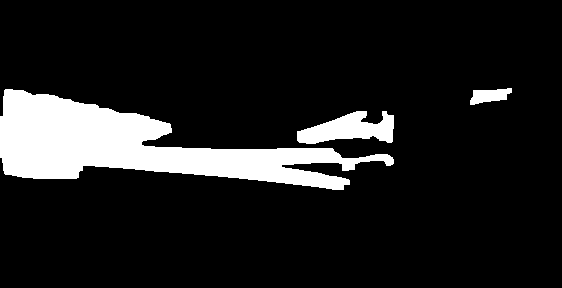

Segmented Image:


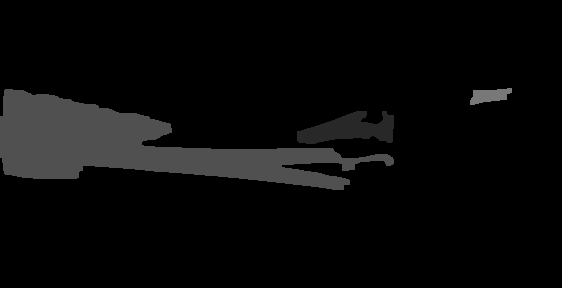

Minimum distance is 8.94 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:


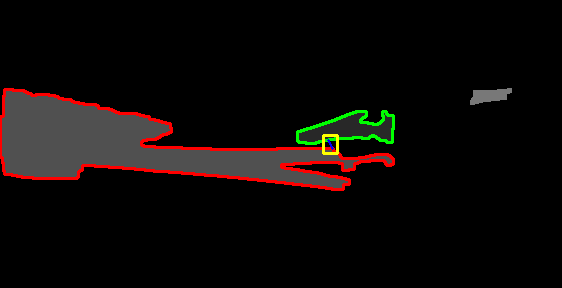

In [48]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Step 1: Load the X-ray image
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to load the image from {image_path}. Check the file path.")
    return image

# Step 2: Simple Preprocessing using Gaussian Blur and fixed thresholding
def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 160, 255, cv2.THRESH_BINARY)

    # Erosion to reduce noise while preserving main structures
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=1)

    return eroded

# Step 3: Detect edges using Canny Edge Detection
def detect_edges(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

def retain_largest_white_areas(binary_image,area):
    # Find connected components in the binary image
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=4)

    # Stats: [x, y, width, height, area] for each component
    # Sort components by area, excluding the background (label 0)
    sorted_stats = sorted(
        [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)],
        key=lambda x: x[1],
        reverse=True
    )

    # Define a blank mask for the output
    filtered_mask = np.zeros_like(binary_image)

    # Retain only components that meet a certain size threshold or are among the largest
    area_threshold = area  # Adjust based on the expected size of meaningful areas
    for i, area in sorted_stats:
        if area > area_threshold:
            filtered_mask[labels == i] = 255  # Retain this component

    return filtered_mask
# Step 4: Detect edges using Canny Edge Detection
def detect_edges(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

def segment_image(binary_image):
    # Find contours of the segmented areas
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to visualize segmentation
    segmented_image = np.zeros_like(binary_image)

    # Draw each contour with a unique label
    for i, contour in enumerate(contours):
        # Use a unique color for each segment
        color = (i + 1) * 40  # Adjust to differentiate segments
        cv2.drawContours(segmented_image, [contour], -1, color, thickness=cv2.FILLED)

    return segmented_image
def break_thin_connections(binary_image):
    # Apply morphological opening to break thin connections
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))  # Larger kernel to target thin connections
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return opened

def highlight_closest_areas_by_boundary(segmented_image):
    """
    Find and highlight the two closest areas based on boundary-to-boundary distance.
    """
    # Find contours of the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) < 2:
        print("Not enough areas to compute distances.")
        return segmented_image

    # Create an image to visualize the result
    proximity_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)

    # Variables to track the minimum distance and the closest pair
    min_distance = float("inf")
    closest_pair = None
    closest_points = None

    # Calculate the minimum boundary-to-boundary distance
    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            if i >= j:  # Avoid duplicate comparisons
                continue

            # Iterate over all points in contour1
            for point1 in contour1:
                point1 = point1[0]  # Extract the point (x, y)
                # Iterate over all points in contour2
                for point2 in contour2:
                    point2 = point2[0]  # Extract the point (x, y)
                    # Compute the Euclidean distance
                    distance = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        closest_pair = (i, j)
                        closest_points = (tuple(point1), tuple(point2))

    # Highlight the closest pair
    if closest_pair and closest_points:
        contour1 = contours[closest_pair[0]]
        contour2 = contours[closest_pair[1]]
        point1, point2 = closest_points

        cv2.drawContours(proximity_image, [contour1], -1, (0, 255, 0), 2)  # Green for first contour
        cv2.drawContours(proximity_image, [contour2], -1, (0, 0, 255), 2)  # Red for second contour
        cv2.line(proximity_image, point1, point2, (255, 0, 0), 2)  # Blue line between closest points
        print(f"Minimum distance is {min_distance:.2f} pixels between contours {closest_pair[0]} and {closest_pair[1]}.")

    return proximity_image

def highlight_closest_areas_by_boundary_with_rectangle(segmented_image):
    """
    Find and highlight the two closest areas based on boundary-to-boundary distance,
    and draw a small rectangle around the closest contact point.
    """
    # Find contours of the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) < 2:
        print("Not enough areas to compute distances.")
        return segmented_image

    # Create an image to visualize the result
    proximity_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)

    # Variables to track the minimum distance and the closest pair
    min_distance = float("inf")
    closest_pair = None
    closest_points = None

    # Calculate the minimum boundary-to-boundary distance
    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            if i >= j:  # Avoid duplicate comparisons
                continue

            # Iterate over all points in contour1
            for point1 in contour1:
                point1 = point1[0]  # Extract the point (x, y)
                # Iterate over all points in contour2
                for point2 in contour2:
                    point2 = point2[0]  # Extract the point (x, y)
                    # Compute the Euclidean distance
                    distance = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        closest_pair = (i, j)
                        closest_points = (tuple(point1), tuple(point2))

    # Highlight the closest pair
    if closest_pair and closest_points:
        contour1 = contours[closest_pair[0]]
        contour2 = contours[closest_pair[1]]
        point1, point2 = closest_points

        # Draw the contours
        cv2.drawContours(proximity_image, [contour1], -1, (0, 255, 0), 2)  # Green for first contour
        cv2.drawContours(proximity_image, [contour2], -1, (0, 0, 255), 2)  # Red for second contour

        # Draw a line connecting the closest points
        cv2.line(proximity_image, point1, point2, (255, 0, 0), 2)  # Blue line between closest points

        # Draw a small rectangle around the closest contact point
        rect_size = 10  # Size of the rectangle (adjust as needed)
        rect_start = (min(point1[0], point2[0]) - rect_size // 2, min(point1[1], point2[1]) - rect_size // 2)
        rect_end = (max(point1[0], point2[0]) + rect_size // 2, max(point1[1], point2[1]) + rect_size // 2)
        cv2.rectangle(proximity_image, rect_start, rect_end, (0, 255, 255), 2)  # Yellow rectangle

        print(f"Minimum distance is {min_distance:.2f} pixels between contours {closest_pair[0]} and {closest_pair[1]}.")

    return proximity_image

# Updated Main Function
def bone_fracture_detection(image_paths):
    for i, image_path in enumerate(image_paths):
        print(f"Processing Image {i+1}...")

        # Load the image
        original_image = load_image(image_path)
        if original_image is None:
            continue

        print("Original Image:")
        cv2_imshow(original_image)

        # Preprocess (apply binary thresholding)
        preprocessed = preprocess_image(original_image)
        print("Binary Image After Thresholding:")
        cv2_imshow(preprocessed)

        # Retain only the largest white areas
        cleaned_binary = retain_largest_white_areas(preprocessed,500)
        print("Cleaned Binary Image (Largest White Areas Retained):")
        cv2_imshow(cleaned_binary)

        disconnected_binary = break_thin_connections(cleaned_binary)
        print("Binary Image After Breaking Thin Connections:")
        cv2_imshow(disconnected_binary)

        cleaned_binary_d = retain_largest_white_areas(disconnected_binary,100)
        print("Cleaned Binary Image after disconnecting:")
        cv2_imshow(cleaned_binary_d)





           # Segment the retained binary image
        segmented = segment_image(cleaned_binary_d)
        print("Segmented Image:")
        cv2_imshow(segmented)


        proximity_image = highlight_closest_areas_by_boundary_with_rectangle(segmented)
        print("Highlighting Closest Areas by Boundary-to-Boundary Distance:")
        cv2_imshow(proximity_image)

# Provide a list of image paths to process
image_paths = ['fracture.jpg', 'fr.jpg', 'fracture3.jfif','arm3.png']
bone_fracture_detection(image_paths)


Processing Image 1...
Original Image:


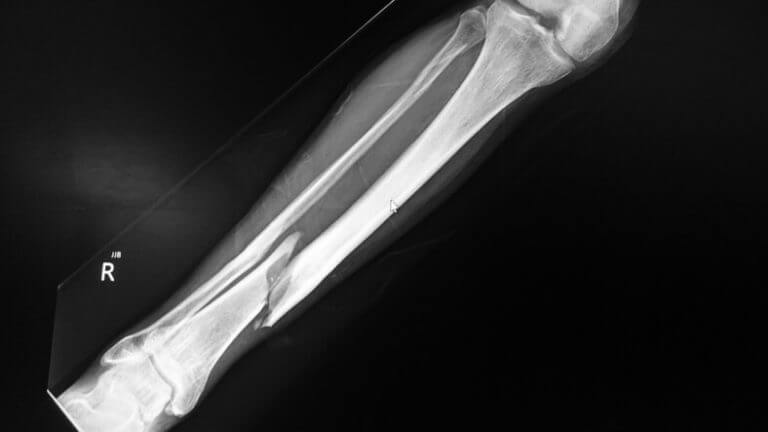

Binary Image After Thresholding:
Cleaned Binary Image (Largest White Areas Retained):
Binary Image After Breaking Thin Connections:
Cleaned Binary Image after disconnecting:
Edge Detection:
Segmented Image:
Minimum distance is 4.47 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:
Original Image with Contact Box:


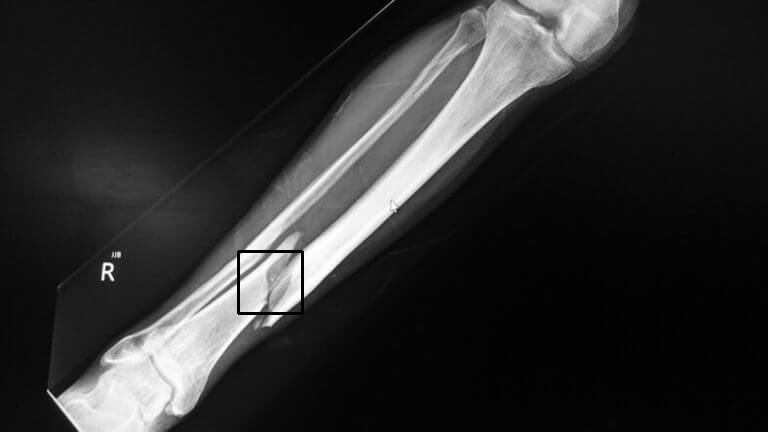

Processing Image 2...
Original Image:


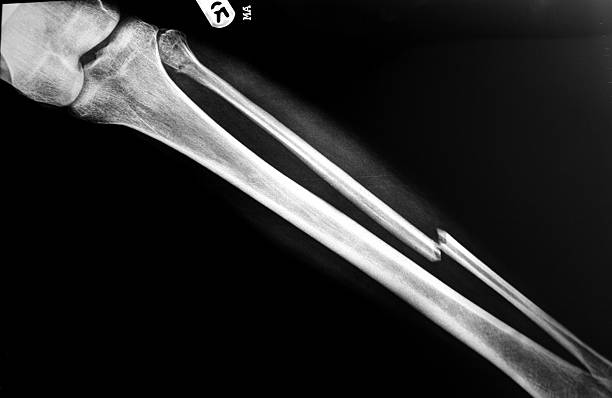

Binary Image After Thresholding:
Cleaned Binary Image (Largest White Areas Retained):
Binary Image After Breaking Thin Connections:
Cleaned Binary Image after disconnecting:
Edge Detection:
Segmented Image:
Minimum distance is 6.32 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:
Original Image with Contact Box:


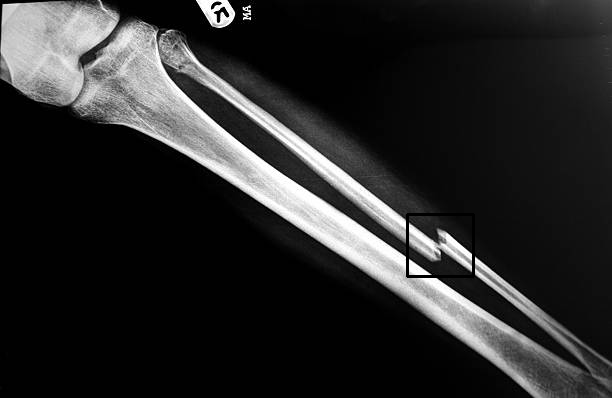

Processing Image 3...
Original Image:


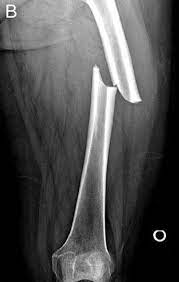

Binary Image After Thresholding:
Cleaned Binary Image (Largest White Areas Retained):
Binary Image After Breaking Thin Connections:
Cleaned Binary Image after disconnecting:
Edge Detection:
Segmented Image:
Minimum distance is 2.00 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:
Original Image with Contact Box:


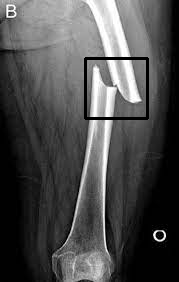

Processing Image 4...
Original Image:


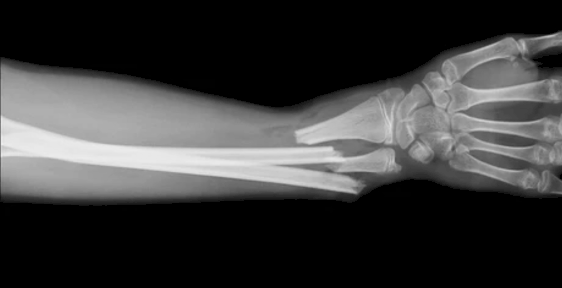

Binary Image After Thresholding:
Cleaned Binary Image (Largest White Areas Retained):
Binary Image After Breaking Thin Connections:
Cleaned Binary Image after disconnecting:
Edge Detection:
Segmented Image:
Minimum distance is 8.94 pixels between contours 0 and 1.
Highlighting Closest Areas by Boundary-to-Boundary Distance:
Original Image with Contact Box:


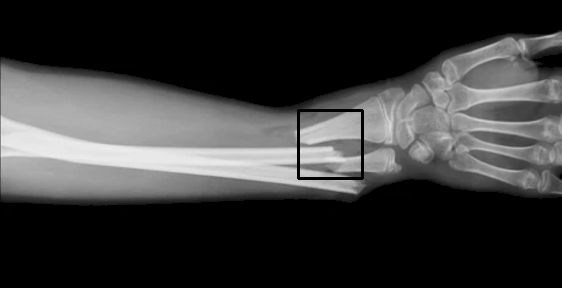

In [50]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Step 1: Load the X-ray image
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to load the image from {image_path}. Check the file path.")
    return image

# Step 2: Simple Preprocessing using Gaussian Blur and fixed thresholding
def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 160, 255, cv2.THRESH_BINARY)

    # Erosion to reduce noise while preserving main structures
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=1)

    return eroded

# Step 3: Detect edges using Canny Edge Detection
def detect_edges(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

def retain_largest_white_areas(binary_image,area):
    # Find connected components in the binary image
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=4)

    # Stats: [x, y, width, height, area] for each component
    # Sort components by area, excluding the background (label 0)
    sorted_stats = sorted(
        [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)],
        key=lambda x: x[1],
        reverse=True
    )

    # Define a blank mask for the output
    filtered_mask = np.zeros_like(binary_image)

    # Retain only components that meet a certain size threshold or are among the largest
    area_threshold = area  # Adjust based on the expected size of meaningful areas
    for i, area in sorted_stats:
        if area > area_threshold:
            filtered_mask[labels == i] = 255  # Retain this component

    return filtered_mask
# Step 4: Detect edges using Canny Edge Detection
def detect_edges(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

def segment_image(binary_image):
    # Find contours of the segmented areas
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to visualize segmentation
    segmented_image = np.zeros_like(binary_image)

    # Draw each contour with a unique label
    for i, contour in enumerate(contours):
        # Use a unique color for each segment
        color = (i + 1) * 40  # Adjust to differentiate segments
        cv2.drawContours(segmented_image, [contour], -1, color, thickness=cv2.FILLED)

    return segmented_image
def break_thin_connections(binary_image):
    # Apply morphological opening to break thin connections
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))  # Larger kernel to target thin connections
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return opened

def highlight_closest_areas_by_boundary(segmented_image):
    """
    Find and highlight the two closest areas based on boundary-to-boundary distance.
    """
    # Find contours of the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) < 2:
        print("Not enough areas to compute distances.")
        return segmented_image

    # Create an image to visualize the result
    proximity_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)

    # Variables to track the minimum distance and the closest pair
    min_distance = float("inf")
    closest_pair = None
    closest_points = None

    # Calculate the minimum boundary-to-boundary distance
    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            if i >= j:  # Avoid duplicate comparisons
                continue

            # Iterate over all points in contour1
            for point1 in contour1:
                point1 = point1[0]  # Extract the point (x, y)
                # Iterate over all points in contour2
                for point2 in contour2:
                    point2 = point2[0]  # Extract the point (x, y)
                    # Compute the Euclidean distance
                    distance = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        closest_pair = (i, j)
                        closest_points = (tuple(point1), tuple(point2))

    # Highlight the closest pair
    if closest_pair and closest_points:
        contour1 = contours[closest_pair[0]]
        contour2 = contours[closest_pair[1]]
        point1, point2 = closest_points

        cv2.drawContours(proximity_image, [contour1], -1, (0, 255, 0), 2)  # Green for first contour
        cv2.drawContours(proximity_image, [contour2], -1, (0, 0, 255), 2)  # Red for second contour
        cv2.line(proximity_image, point1, point2, (255, 0, 0), 2)  # Blue line between closest points
        print(f"Minimum distance is {min_distance:.2f} pixels between contours {closest_pair[0]} and {closest_pair[1]}.")

    return proximity_image

def highlight_closest_areas_by_boundary_with_rectangle(segmented_image):
    """
    Find and highlight the two closest areas based on boundary-to-boundary distance,
    and draw a small rectangle around the closest contact point.
    """
    # Find contours of the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) < 2:
        print("Not enough areas to compute distances.")
        return segmented_image

    # Create an image to visualize the result
    proximity_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)

    # Variables to track the minimum distance and the closest pair
    min_distance = float("inf")
    closest_pair = None
    closest_points = None

    # Calculate the minimum boundary-to-boundary distance
    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            if i >= j:  # Avoid duplicate comparisons
                continue

            # Iterate over all points in contour1
            for point1 in contour1:
                point1 = point1[0]  # Extract the point (x, y)
                # Iterate over all points in contour2
                for point2 in contour2:
                    point2 = point2[0]  # Extract the point (x, y)
                    # Compute the Euclidean distance
                    distance = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        closest_pair = (i, j)
                        closest_points = (tuple(point1), tuple(point2))

    # Highlight the closest pair
    if closest_pair and closest_points:
        contour1 = contours[closest_pair[0]]
        contour2 = contours[closest_pair[1]]
        point1, point2 = closest_points

        # Draw the contours
        cv2.drawContours(proximity_image, [contour1], -1, (0, 255, 0), 2)  # Green for first contour
        cv2.drawContours(proximity_image, [contour2], -1, (0, 0, 255), 2)  # Red for second contour

        # Draw a line connecting the closest points
        cv2.line(proximity_image, point1, point2, (255, 0, 0), 2)  # Blue line between closest points

        # Draw a small rectangle around the closest contact point
        rect_size = 10  # Size of the rectangle (adjust as needed)
        rect_start = (min(point1[0], point2[0]) - rect_size // 2, min(point1[1], point2[1]) - rect_size // 2)
        rect_end = (max(point1[0], point2[0]) + rect_size // 2, max(point1[1], point2[1]) + rect_size // 2)
        cv2.rectangle(proximity_image, rect_start, rect_end, (0, 255, 255), 2)  # Yellow rectangle

        print(f"Minimum distance is {min_distance:.2f} pixels between contours {closest_pair[0]} and {closest_pair[1]}.")

    return proximity_image
def color_closest_areas(segmented_image):
    """
    Color the closest areas based on boundary-to-boundary distance.
    """
    # Find contours of the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) < 2:
        print("Not enough areas to compute distances.")
        return segmented_image, None

    # Create an image to visualize the result
    proximity_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)

    # Variables to track the minimum distance and the closest pair
    min_distance = float("inf")
    closest_pair = None
    closest_points = None

    # Calculate the minimum boundary-to-boundary distance
    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            if i >= j:  # Avoid duplicate comparisons
                continue

            # Iterate over all points in contour1
            for point1 in contour1:
                point1 = point1[0]  # Extract the point (x, y)
                # Iterate over all points in contour2
                for point2 in contour2:
                    point2 = point2[0]  # Extract the point (x, y)
                    # Compute the Euclidean distance
                    distance = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
                    if distance < min_distance:
                        min_distance = distance
                        closest_pair = (i, j)
                        closest_points = (tuple(point1), tuple(point2))

    # Highlight the closest pair
    if closest_pair and closest_points:
        contour1 = contours[closest_pair[0]]
        contour2 = contours[closest_pair[1]]
        point1, point2 = closest_points

        # Draw the contours
        cv2.drawContours(proximity_image, [contour1], -1, (0, 255, 0), 2)  # Green for first contour
        cv2.drawContours(proximity_image, [contour2], -1, (0, 0, 255), 2)  # Red for second contour
        cv2.line(proximity_image, point1, point2, (255, 0, 0), 2)  # Blue line between closest points

        print(f"Minimum distance is {min_distance:.2f} pixels between contours {closest_pair[0]} and {closest_pair[1]}.")
        return proximity_image, closest_points

    return proximity_image, None


def draw_contact_box_on_original(original_image, closest_points):
    """
    Draw a small rectangle around the contact point on the original image.
    """
    if not closest_points:
        print("No closest points to draw a box around.")
        return original_image

    # Extract the closest points
    point1, point2 = closest_points

    # Define the rectangle
    rect_size = 60  # Size of the rectangle (adjust as needed)
    rect_start = (min(point1[0], point2[0]) - rect_size // 2, min(point1[1], point2[1]) - rect_size // 2)
    rect_end = (max(point1[0], point2[0]) + rect_size // 2, max(point1[1], point2[1]) + rect_size // 2)

    # Draw the rectangle on the original image
    output_image = original_image.copy()
    cv2.rectangle(output_image, rect_start, rect_end, (0, 255, 0), 2)  # Yellow rectangle
    return output_image

# Updated Main Function
def bone_fracture_detection(image_paths):
    for i, image_path in enumerate(image_paths):
        print(f"Processing Image {i+1}...")

        # Load the image
        original_image = load_image(image_path)
        if original_image is None:
            continue

        print("Original Image:")
        cv2_imshow(original_image)

        # Preprocess (apply binary thresholding)
        preprocessed = preprocess_image(original_image)
        print("Binary Image After Thresholding:")

        # Retain only the largest white areas
        cleaned_binary = retain_largest_white_areas(preprocessed,500)
        print("Cleaned Binary Image (Largest White Areas Retained):")

        disconnected_binary = break_thin_connections(cleaned_binary)
        print("Binary Image After Breaking Thin Connections:")

        cleaned_binary_d = retain_largest_white_areas(disconnected_binary,100)
        print("Cleaned Binary Image after disconnecting:")



        edges = detect_edges(cleaned_binary_d)
        print("Edge Detection:")

           # Segment the retained binary image
        segmented = segment_image(cleaned_binary_d)
        print("Segmented Image:")

        proximity_image, closest_points = color_closest_areas(segmented)
        print("Highlighting Closest Areas by Boundary-to-Boundary Distance:")

        # Draw contact box on the original image
        output_image = draw_contact_box_on_original(original_image, closest_points)
        print("Original Image with Contact Box:")
        cv2_imshow(output_image)

# Provide a list of image paths to process
image_paths = ['fracture.jpg', 'fr.jpg', 'fracture3.jfif','arm3.png']
bone_fracture_detection(image_paths)
